In [16]:
import numpy as np
from matplotlib import pyplot as plt
from scipy.integrate import solve_ivp
import math

Defining an ODE that does SIR population Dynamics and the capital growth equation in a single ODE

In [ ]:
def population_with_captial_growth(fertility_rate=2.1, life_expectancy=85, fertility_starts=18, fertility_ends=40,A=1,alpha=.5,delta=0.08,s=.3):
    #TODO: incorporate Michael's capital effectiveness that changes with age
    #TODO: make it so that n incorporates arbitrary ages for entering/leaving the labor force
    # Validate input parameters
    if not isinstance(life_expectancy, int):
        raise ValueError("Life expectancy must be an integer in this model")
    elif life_expectancy < 40:
        raise ValueError("This model requires life_expectancy to be at least 40")

    def ode(t, x):
        """
        Ordinary differential equation representing the SIR population dynamics with granular fertility
        AND the capital growth model.
        Incorporates a population schock at time t=50 where 10% of the 18-40 population die

        Parameters:
        - t: Time variable.
        - x: Array representing the state variables, where x[i] represents the number of people at age i.
        x[:-1] = population of each age group
        x[-1] = capital k

        Returns:
        - dx: Array representing the rates of change of the state variables.
        dx[:-1] = change in population of each age group
        dx[-1] =  k' (change of capital)
        """
        dx = np.zeros_like(x)

        # Calculate the births based on the fertility rate
        if callable(fertility_rate):
            dx[0] = 0.5 * fertility_rate(t) * np.mean(x[fertility_starts:fertility_ends + 1])-x[0]
        else:
            dx[0] = 0.5 * fertility_rate * np.mean(x[fertility_starts:fertility_ends + 1]) - x[0]

        # Calculate the change in other age categories
        dx[1:-1] = x[:-2] - x[1:-1]
        # dx[1:] = x[:-1] - x[1:]
        
        #Calculate current working population rate change
        n = (dx[18] - dx[66])/np.sum(x[18:66])

        #Define a function to return the income per person in the economy. 
        def y(k, alpha=alpha, A=A):
            if callable(A):
                return A(t)*k**alpha
            else:
                return A*k**alpha

        #The captital evolution equation
        def kprime(k, alpha=alpha, s=s, delta=delta, n=n, A=A):
            return s*y(k, alpha, A) - (delta + n)*k
        
        #Define the last element of dx to be capital growth
        dx[-1] = kprime(x[-1], alpha=alpha, s=s, delta=delta, n=n, A=A)

        return dx
    return ode

Consolidate Age Groups Function

In [3]:
def consolidate_age_groups(x,age_brackets = [18,40,65],return_labels = False):
    age_brackets.sort()
    M = [0]+age_brackets + [len(x)]
    ns = np.array([np.sum(x[M[i]:M[i+1]],axis = 0)for i in range(len(M)-1)])
    if return_labels:
        labels = [f"{M[i]}-{M[i+1]}" for i in range(len(M)-1)]
        return ns,labels
    else:
        return ns

### Simulating the effect on a war on a country's economy:
We will now modify the granular population model to have a shock in which 10% of all 18-40 year olds die in a war, 10% of the country's capital is lost in the war
We then use the following equations:
$$\dot n_0 = \frac {1} {2} r_f \sum_{i = 20}^{40} \frac{n_i}{20}$$
$$\dot n_i = n_{i-1} - n_i, \ \forall i \in \{1,2,...,k\}$$
Where $r_f$ is the fertility rate and $k$ is the 'life expectancy'.


49.67833026344834
49.959272076084744
50.05219279805839
50.168343700525455
50.168343700525455
50.377415324966165
50.48195113718652


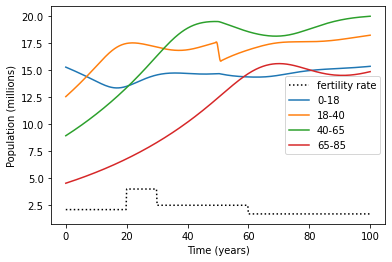

In [23]:
def population_with_captial_growth(fertility_rate=2.1, life_expectancy=85, fertility_starts=18, fertility_ends=40,A=1,alpha=.5,delta=0.08,s=.3):
    #TODO: incorporate Michael's capital effectiveness that changes with age
    #TODO: make it so that n incorporates arbitrary ages for entering/leaving the labor force
    # Validate input parameters
    if not isinstance(life_expectancy, int):
        raise ValueError("Life expectancy must be an integer in this model")
    elif life_expectancy < 40:
        raise ValueError("This model requires life_expectancy to be at least 40")

    def ode(t, x):
        """
        Ordinary differential equation representing the SIR population dynamics with granular fertility
        AND the capital growth model.
        Incorporates a population schock at time t=50 where 10% of the 18-40 population die

        Parameters:
        - t: Time variable.
        - x: Array representing the state variables, where x[i] represents the number of people at age i.
        x[:-1] = population of each age group
        x[-1] = capital k

        Returns:
        - dx: Array representing the rates of change of the state variables.
        dx[:-1] = change in population of each age group
        dx[-1] =  k' (change of capital)
        """
        dx = np.zeros_like(x)

        # Calculate the births based on the fertility rate
        if callable(fertility_rate):
            dx[0] = 0.5 * fertility_rate(t) * np.mean(x[fertility_starts:fertility_ends + 1])-x[0]
        else:
            dx[0] = 0.5 * fertility_rate * np.mean(x[fertility_starts:fertility_ends + 1]) - x[0]

        # Calculate the change in other age categories
        dx[1:-1] = x[:-2] - x[1:-1]
        # dx[1:] = x[:-1] - x[1:]
        
        #Calculate current working population rate change
        n = (dx[18] - dx[66])/np.sum(x[18:66])

        #Define a function to return the income per person in the economy. 
        def y(k, alpha=alpha, A=A):
            if callable(A):
                return A(t)*k**alpha
            else:
                return A*k**alpha

        #The captital evolution equation
        def kprime(k, alpha=alpha, s=s, delta=delta, n=n, A=A):
            return s*y(k, alpha, A) - (delta + n)*k
        
        dx[-1] = kprime(x[-1], alpha=alpha, s=s, delta=delta, n=n, A=A)



        return dx
    
    


    return ode



Now do the capital schock

In [ ]:

# #Model the population & capital shock:
# if 49.5<= t and t <=50.5:
#     dx[18:40] = -.1*x[18:40]

# Here we initialize the ode function to solve
ode = population_SIR_granular_with_schock(fertility_rate=2.1, life_expectancy=85, fertility_starts=18, fertility_ends=40)

ts = np.linspace(0,100,501)
# Here we set the initial population
x0 = np.exp(-.02*np.arange(life_expect))

sol =solve_ivp(ode,(0,100),x0,t_eval=ts)
# Here consolidate the ages into age brackets, to make the data more visible
# Grouping the age brackets will also make it easier for our model
values,labels = consolidate_age_groups(sol.y,return_labels=True)

# Here we plot the results
plt.plot(sol.t,fertility_rate(sol.t),":k",label = "fertility rate")
plt.plot(sol.t,values.T,label = labels)
plt.legend()
plt.xlabel("Time (years)")
plt.ylabel("Population (millions)")
plt.show()